In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats, signal
import pandas as pd

In [7]:
phononmodes = 6
steps = 20
data = pd.DataFrame({
    'phononmode': [], 'l':[], 'k': [], 'k2': [], 'E': [], 'E2': [], 'err': [], 'err2': []
})
data

def norm(x,mu,std,k):
    return  k*(np.exp(-(x-mu)**2/std**2))

def twonorm(x,mu1, mu2, std1, std2, k1, k2):
    return  k1*(np.exp(-(x-mu1)**2/std1**2)) + k2*(np.exp(-(x-mu2)**2/std2**2))

def get_data(i,j):
    l=round(1.5+0.05*j,ndigits=2)
    gendata = np.genfromtxt(f'tester_Eigen/Eigen_Phononkomponent/PH{i}_h0_l{l}/mccode.dat', delimiter = '', usecols = (0,-2,-1))
    print(i,l)
    x_data=gendata[:,0] 
    y_data=gendata[:,1]
    err_data=gendata[:,2]
    err_data[err_data == 0] =err_data[np.where(y_data==np.min(y_data[y_data>0]))]
    return x_data, y_data, err_data, l

def kør(data, steps, phononmodes):
    for i in range(phononmodes):
        for j in range(steps):
            x_data, y_data, err_data,l= get_data(i,j)
            data.loc[i*phononmodes+j, 'phononmode'] = i
            data.loc[i*phononmodes+j, 'l']=l
            peaks = signal.find_peaks(y_data, height=0.5e6, distance=20)
            if len(peaks[0])==1:
                par,cov = curve_fit(norm, x_data, y_data, p0=[x_data[peaks[0][0]], 1, y_data[peaks[0][0]]], sigma=err_data)
                data.loc[i*phononmodes+j, 'E']=par[0] 
                data.loc[i*phononmodes+j, 'err']=np.sqrt(cov[0][0])
                data.loc[i*phononmodes+j, 'k']=par[2]

            if len(peaks[0])==2:
                par,cov = curve_fit(twonorm, x_data, y_data, p0=[x_data[peaks[0][0]], x_data[peaks[0][1]], 1, 1, y_data[peaks[0][0]], y_data[peaks[0][1]]], sigma=err_data)
                data.loc[i*phononmodes+j, 'E']=par[0]
                data.loc[i*phononmodes+j, 'E2']=par[1]
                data.loc[i*phononmodes+j, 'err']=np.sqrt(cov[0][0])
                data.loc[i*phononmodes+j, 'err2']=np.sqrt(cov[1][1])
                data.loc[i*phononmodes+j, 'k1']=par[4]
                data.loc[i*phononmodes+j, 'k2']=par[5]
            
            if len(peaks[0])==3:
                par,cov = curve_fit(twonorm, x_data, y_data, p0=[x_data[peaks[0][0]], x_data[peaks[0][1]],x_data[peaks[0][2]], 0.5, 0.5, 0.5, y_data[peaks[0][0]], y_data[peaks[0][1]], y_data[peaks[0][2]]], sigma=err_data)
                data.loc[i*steps+j, 'E']=par[0]
                data.loc[i*steps+j, 'E2']=par[1]
                data.loc[i*steps+j, 'err']=np.sqrt(cov[0][0])
                data.loc[i*steps+j, 'err2']=np.sqrt(cov[1][1])
                data.loc[i*steps+j, 'k']=par[4]
                data.loc[i*steps+j, 'k2']=par[5]

            else:
                continue

        
        print(f'Phononmode {i} er færdig')
    return  data

data=kør(data,steps,phononmodes)  
data


OSError: tester_Eigen/Eigen_Phononkomponent/PH0_h0_l1.5/mccode.dat not found.

<ErrorbarContainer object of 3 artists>

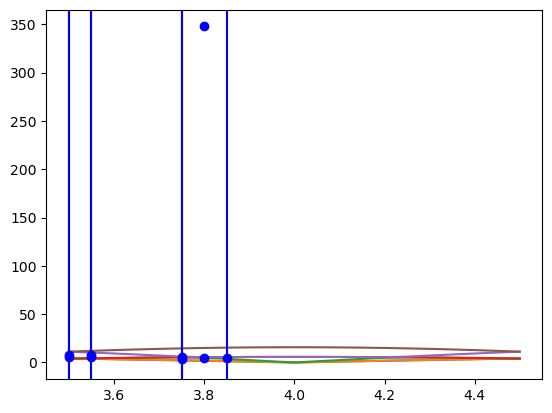

In [58]:
phonon_data = np.genfromtxt('PG_dispersion.csv', delimiter=',')
q_data=phonon_data[:,0]    
E_phonon_data=phonon_data[:,1:]
plt.plot(q_data, E_phonon_data)
plt.errorbar(data.l, data.E, yerr=data.err, fmt='o', c='blue', label='Data')  
plt.errorbar(data.l, data.E2, yerr=data.err2, fmt='o',c='blue', label='Data')

In [61]:
def chisqrt(k, phonondata, phononerror):
    print('phononmode',k,'chi2', np.sum(((phonondata-E_phonon_data[k])/phononerror)**2), 'redchi2', np.sum(((phonondata-E_phonon_data[k])/phononerror)**2)/steps)

for i in range(phononmodes):
    chisqrt(i, data.E[steps*i:steps(i+1)], data.err[steps*i:steps(i+1)])



TypeError: 'int' object is not callable